Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

Read data 

In [2]:
#import pandas as pd
data=pd.read_csv("Random Forest results.CSV" )
data['Date'] = pd.to_datetime(data['Date'])
dataset=data.set_index(data['Date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('Date', 1)
#dataset.head(2)
#data

<ipython-input-2-88db98cd03e7>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataset=data.set_index(data['Date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('Date', 1)


Add year & month column

✈ 🏸 Feature engineering

In [3]:
#['year'] = pd.DatetimeIndex(df2['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['day'] = pd.DatetimeIndex(data['Date']).day
data.head(2)

,Date,Load,LBMP,DI,WC,wetbulb,T2MWET,winddirection,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,specifichumidity,PS,month,day
0,2016-01-01 00:00:00,4894.5,213.20,37.974654,2.616960,1.30,2.00,300.90,0.0,0.0,0.0,4.15,101.28,1,1
1,2016-01-01 01:00:00,4712.7,19.08,37.706599,2.621161,1.01,1.76,298.94,0.0,0.0,0.0,4.03,101.27,1,1


onehot_encode_integers & nomrlize load data

✈ 🏸 Special one hot encoding for time-series data

✈ 🏸 MinMaxScalar

In [4]:
def select_columns(df):
  cols_to_keep = [       
      'Load',
      'LBMP',
      'month',
      'day',

  ]
  df_subset = df[cols_to_keep]
  return df_subset

def onehot_encode_integers(df, excluded_cols):
  df = df.copy()

  int_cols = [col for col in df.select_dtypes(include=['int'])
              if col not in excluded_cols]

  df.loc[:,int_cols] = df.loc[:,int_cols].astype('str')

  df_encoded = pd.get_dummies(df)
  return df_encoded

def normalize_cnt(df):
    df = df.copy()
    df['Load'] = df['Load'] / df['Load'].max()
    df['LBMP'] = df['LBMP'] / df['LBMP'].max()

    return df

In [5]:
mydata = (data
           .pipe(select_columns)
           .pipe(onehot_encode_integers, 
                 excluded_cols=['cnt'])
           .pipe(normalize_cnt)
)

In [6]:
mydata.head(2)

,Load,LBMP,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,...,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9
0,0.442153,0.115957,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.425730,0.010377,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def create_dataset(df, n_deterministic_features, 
                   window_size, forecast_size, 
                   batch_size):
  # Feel free to play with shuffle buffer size
  shuffle_buffer_size = len(df)
  # Total size of window is given by the number of steps to be considered
  # before prediction time + steps that we want to forecast
  total_size = window_size + forecast_size

  data = tf.data.Dataset.from_tensor_slices(df.values)

  # Selecting windows
  data = data.window(total_size, shift=1, drop_remainder=True)
  data = data.flat_map(lambda k: k.batch(total_size))

  # Shuffling data (seed=Answer to the Ultimate Question of Life, the Universe, and Everything)
  data = data.shuffle(shuffle_buffer_size, seed=42)

  # Extracting past features + deterministic future + labels
  data = data.map(lambda k: ((k[:-forecast_size],
                             k[-forecast_size:,-n_deterministic_features:]),
                             k[-forecast_size:,0]))
  
  return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
mydata

,Load,LBMP,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,...,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9
0,0.442153,0.115957,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.425730,0.010377,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.407455,0.013303,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.394627,0.006195,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.387255,0.001077,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,0.560078,0.013238,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
35036,0.541758,0.011204,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
35037,0.523366,0.011617,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
35038,0.497322,0.011655,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
len(mydata.columns) 

45

In [10]:
# Times at which to split train/validation and validation/test
val_time = 24500
test_time = 29750

# How much data from the past should we need for a forecast?
window_len = 24 # 24-hour
# How far ahead do we want to generate forecasts?
forecast_len = 1 # one-hour ahead

# Auxiliary constants
n_total_features = len(mydata.columns) 
n_aleatoric_features = len(['Load','LBMP'])
n_deterministic_features = n_total_features - n_aleatoric_features

# Splitting dataset into train/val/test
training_data = mydata.iloc[:val_time]
validation_data = mydata.iloc[val_time:test_time]
test_data = mydata.iloc[test_time:]


# Now we get training, validation, and test as tf.data.Dataset objects

batch_size = 32

training_windowed = create_dataset(training_data, 
                                   n_deterministic_features,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(validation_data, 
                                     n_deterministic_features,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test_data, 
                               n_deterministic_features,
                               window_len,
                               forecast_len,
                               batch_size=1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


✈ 🏸 stack lstm 

✈ 🏸 latent dim

✈ 🏸 Dense

✈ 🏸 MAPE

✈ 🏸 encoder input & decoder input

encoder

In [11]:
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True,    
                               return_sequences=True  ### change it to True in order to get 3D output for dot function
)
encoder_outputs, state_h, state_c = encoder(past_inputs)



decoder + attention

In [12]:
from keras.layers import Activation, dot, concatenate

✈ 🏸 Different  kind of attention

In [13]:
future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])

decoder_outputs=x
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])

attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes=[2,1])
decoder_outputs = concatenate([context, decoder_outputs])
x = tf.keras.layers.Dense(16, activation='relu')(decoder_outputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

In [14]:
model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

In [15]:
history = model.fit(training_windowed,epochs=5, validation_data=validation_windowed)

Epoch 1/5
765/765 [==============================] - 40s 32ms/step - loss: 0.0053 - mae: 0.0717 - val_loss: 9.9660e-04 - val_mae: 0.0360
Epoch 2/5
765/765 [==============================] - 21s 22ms/step - loss: 7.9151e-04 - mae: 0.0311 - val_loss: 3.1490e-04 - val_mae: 0.0198
Epoch 3/5
765/765 [==============================] - 19s 20ms/step - loss: 3.0813e-04 - mae: 0.0195 - val_loss: 2.3559e-04 - val_mae: 0.0171
Epoch 4/5
765/765 [==============================] - 20s 21ms/step - loss: 2.1088e-04 - mae: 0.0163 - val_loss: 1.7574e-04 - val_mae: 0.0151
Epoch 5/5
765/765 [==============================] - 20s 21ms/step - loss: 1.8153e-04 - mae: 0.0152 - val_loss: 1.5421e-04 - val_mae: 0.0141


✈ 🏸 best epoch + early stopping

✈ 🏸 plot of loss and val_loss

In [17]:
model.evaluate(test_windowed)

5266/5266 [==============================] - 41s 8ms/step - loss: 1.7531e-04 - mae: 0.0149


[0.00017531208868604153, 0.014920123852789402]

✈ 🏸 name different layers in order to ck them

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 past_inputs (InputLayer)       [(None, 24, 45)]     0           []                               
                                                                                                  
 future_inputs (InputLayer)     [(None, 1, 43)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 24, 16),     3968        ['past_inputs[0][0]']            
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                              

[Plot a tensorflow model](https://towardsdatascience.com/plot-a-tensorflow-model-with-keras-functional-api-f2db639dbbd8)

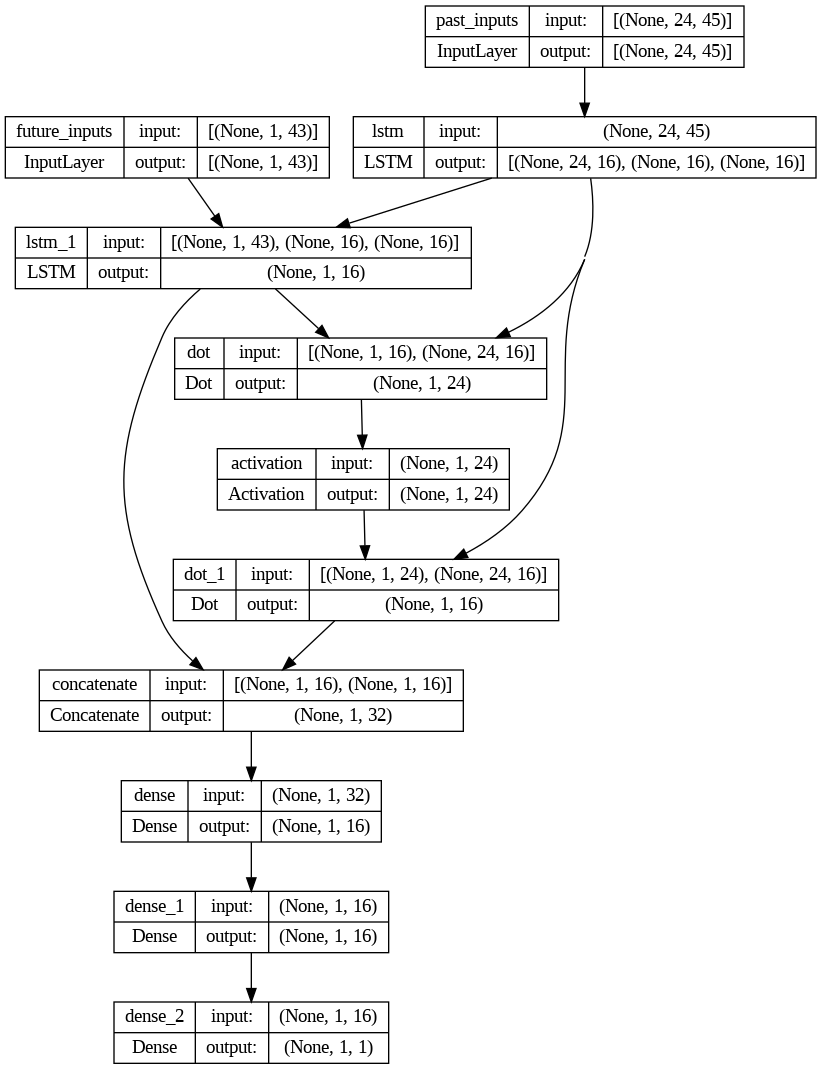

In [19]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)